<a href="https://colab.research.google.com/github/tikendraw/question-answer-generation/blob/main/question_answers_genration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answers Generations Model

In [1]:
import os, sys
if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/question-answer-generation.git 
    os.chdir('question-answer-generation') 
    print(os.getcwd())

fatal: destination path 'question-answer-generation' already exists and is not an empty directory.
/content/question-answer-generation


In [2]:
# Dependencies
import pandas as pd
! pip install polars
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dense, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tensorflow_hub
import tensorflow_hub as hub
import os
import re
import json

print('Tf version: ',tf.__version__)
print('GPU: ', is_gpu:=len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if is_gpu:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices)
    print(config)

def download_USEncoder():

    print('downloading universal sentence encoder...')
    !wget https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
    print('Downloaded universal sentence encoder.')
    # Extracting
    try:
        !mkdir universal_sentence_encoder
        print('Extracting universal sentence encoder....')
        ! tar -xf 4.tar.gz --directory ./universal_sentence_encoder
        print('Extracted.')
    except Exception as e:
        print(e)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tf version:  2.9.2
GPU:  0


In [3]:
%run squad_preprocessing.py

In [4]:
# get the data
df = pl.read_csv('dataset/train_data_cleaned.csv')
df.shape, df.to_pandas().info(), type(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0                 86821 non-null  int64 
 1   title         86821 non-null  object
 2   context       86821 non-null  object
 3   questions     86821 non-null  object
 4   final_answer  86821 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


((86821, 5), None, polars.internals.dataframe.frame.DataFrame)

In [5]:
df.sample(5)

,title,context,questions,final_answer
i64,str,str,str,str
7181,"""2008_Summer_Ol...",""" Pakistan: Th...","""Instead of a t...","""Jinnah Stadium..."
18582,"""Paper""","""Conventional b...","""What process o...","""bleaching"""
77794,"""Political_part...","""While there is...","""Name a nation ...","""China"""
12936,"""Oklahoma_City""","""There were 230...","""How many house...","""230,233"""
50000,"""Freemasonry""","""In contrast to...","""Albert Pike's ...","""late 19th cent..."


In [6]:
# null check
df.null_count()

,title,context,questions,final_answer
u32,u32,u32,u32,u32
0,0,0,0,0


In [7]:
#drop nulls
df.drop_nulls()
print('Null removed')

Null removed


# Here we will add a new columns to data which can be a switch wheather we want question and ans from model or just answers

In [8]:
modes = {
    'find_answers':0,
    'geneate_questions': 1
    }


I would like to add the `title` column to `context` . there will a columns less to process.

In [9]:
df = df.with_column(
    (pl.col('title') + '  ' +pl.col('context')).alias('newcontext')
)

In [10]:
df = df.with_columns([
    (pl.col("context").apply(lambda x: len(str(x).split(' '))).alias("context_len")),
    (pl.col("newcontext").apply(lambda x: len(str(x).split(' '))).alias("newcontext_len")),
    (pl.col("questions").apply(lambda x: len(str(x).split(' '))).alias("question_len")),
    (pl.col("final_answer").apply(lambda x: len(str(x).split(' '))).alias("answer_len"))])

In [11]:
df.sample(5)

,title,context,questions,final_answer,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,i64,i64,i64,i64
124913,"""The_Bronx""","""The Bronx unde...","""What led to th...","""Extensions of ...","""The_Bronx The...",116,118,7,7
84849,"""Time""","""A sequence of ...","""What is anothe...","""chronological ...","""Time A sequen...",106,108,8,2
67374,"""Switzerland""","""Similarly, the...","""What must vote...","""indicate a pre...","""Switzerland S...",79,81,12,3
87418,"""George_VI""","""Albert assumed...","""What regnal na...","""George VI""","""George_VI Alb...",175,177,6,2
20064,"""University_of_...","""Notable among ...","""What is the na...","""""Kansas Song""""","""University_of_...",52,54,14,2


# Dataset Analysis

In [12]:
#plotting a verticle axis for 95% mark
def dist_info(x, r:tuple = (90,100), bins:int = 100, title = 'old', xlim:list = None, ylim:list = None):
    
    '''
    this function plot distribution of series with axis lines with given range.
    
    x : series  = series of numbers
    r : tuple   =  tuple with low and high values to plot
    title : str =  title of the plot
    xlim : list = low and high limit to limit the plot
    ylim : list = similar to xlim
    '''
    
    print('Percent  ::   words  \n')
    plt.figure(figsize = (25,5))
    sns.histplot(x = x, bins = bins)

    for percent in range(r[0], r[1]+1):
        perc_x = np.percentile(x, percent)
        print(f'{percent:6}%  ::   {perc_x} words') 
        plt.axvline(x = perc_x, color = 'red')
        plt.text(x = perc_x, y = 2500+np.random.randint(100, 400), s = f'{percent}%')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    if title =='old':
        plt.title(f'Length Distribution of {x.name}')
    else:
        plt.title(str(title))
    # plt.show()


## 1. Context

Percent  ::   words  

    95%  ::   215.0 words
    96%  ::   224.0 words
    97%  ::   236.0 words
    98%  ::   254.0 words
    99%  ::   285.0 words
   100%  ::   655.0 words


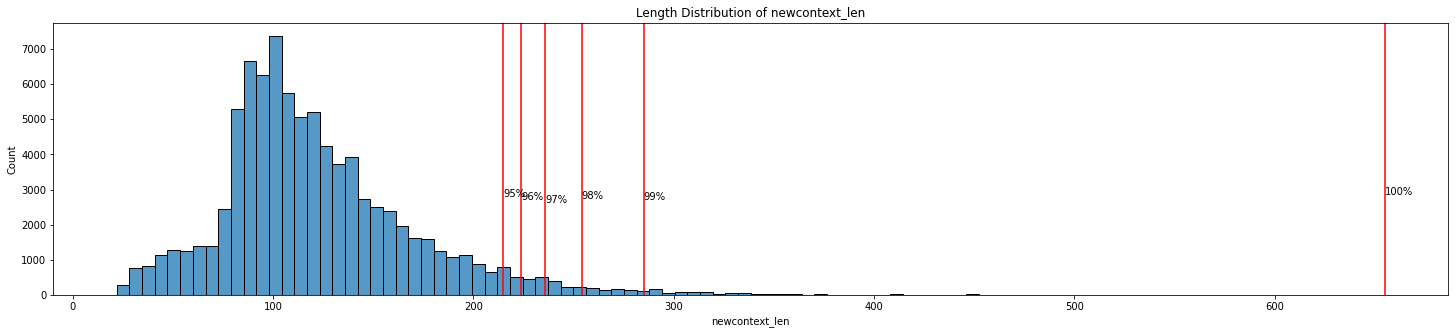

In [13]:
dist_info(df['newcontext_len'], (95,100))


In Order to Cover 100 percent of the data we need to create input length of 653 words which is too much. while just 213 words cover 95 % of the data. 
so lets take 500 words as a context input it will cover99% data.

In [14]:
context_input_len = 500 + 2 # for <SOS> AND <EOS>

In [15]:
# Unique words in  context
# all_words = [i.split() for i in df['newcontext']]

## 2. Questions

In [16]:
df['question_len'].max()

25601

Percent  ::   words  

    95%  ::   17.0 words
    96%  ::   17.0 words
    97%  ::   18.0 words
    98%  ::   19.0 words
    99%  ::   21.0 words


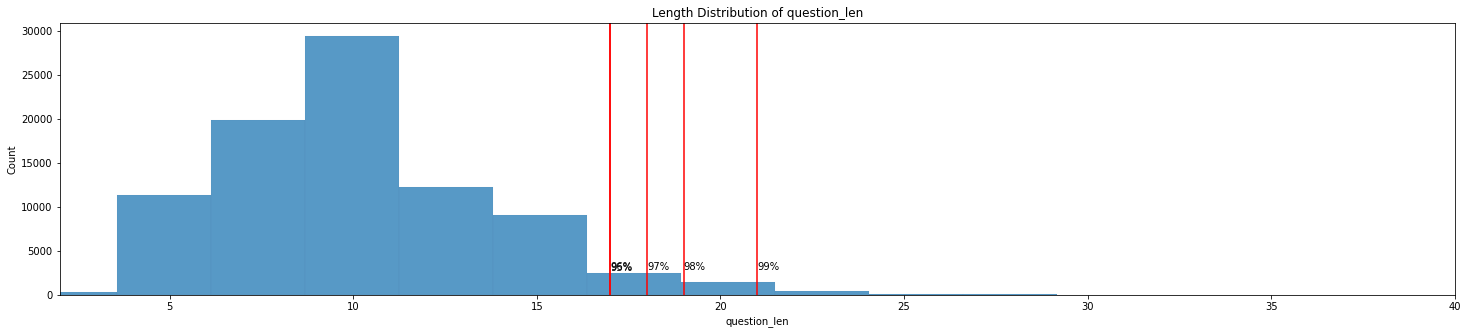

In [17]:
dist_info(x = df['question_len'], r = (95,99), xlim=[2,40], bins = 10000)

clearly there are too much bins 

Similar to context , for input for questions we would go with 50 words , it covers 99% data 

In [18]:
question_inputs_len = 50 + 2 # for <SOS> AND <EOS>

## 3. Answers

Percent  ::   words  

    95%  ::   10.0 words
    96%  ::   11.0 words
    97%  ::   13.0 words
    98%  ::   15.0 words
    99%  ::   18.0 words
   100%  ::   43.0 words


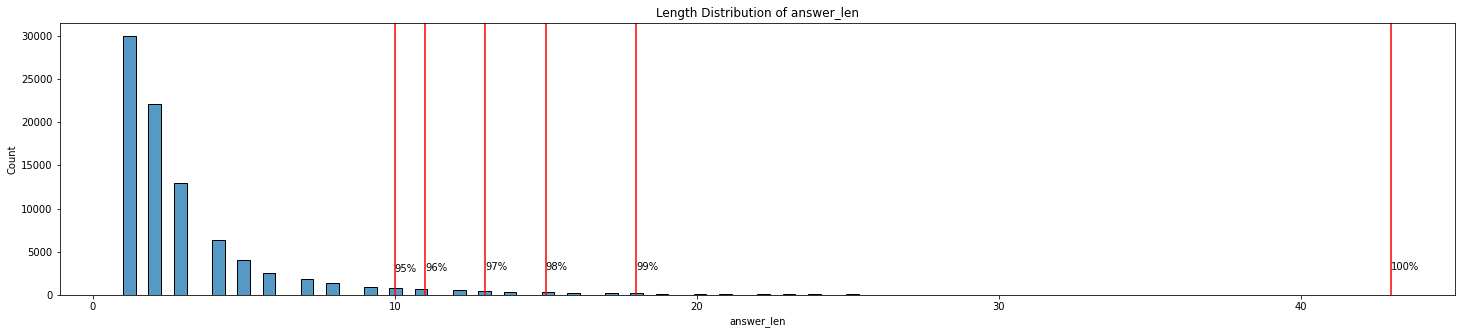

In [19]:
dist_info(df['answer_len'], (95,100))


Similar to context , for input for answers we would go with 50 words , it covers 100% data 

In [20]:
answer_inputs_len = 50 + 2 # for <SOS> AND <EOS>

# Preprocessing TEXT

In [21]:
# FUNCTIONS TO EXPAND CONTRACTIONS

with open('contractions.json') as f:
   contractions_dict = json.load(f)

def cont_to_exp(x):
    x = str(x).lower()
    xsplited = x.split(' ')
    exp_sentence = []
    for s in x.split():
        if s in contractions_dict.keys():
            
            s = contractions_dict.get(s)
        exp_sentence.append(s)
        
    x = ' '.join(exp_sentence)
    return x


In [22]:
# very necessary function you can't tell differece between "’" and "'", I don't even have that symbol in my keyboard
def text_cleaning_apos(text):
    text = str(text)
    text = text.lower()
    text = re.sub("’", "'", text) # removing punctuation
    text = cont_to_exp(text)
    text = re.sub('[#,@,&]', '',text)
    text = re.sub("'s",'', text)
    text = text.replace("?",' ?')
    text = text.replace(".",' .')
    text = text.replace("!",' !')
    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    return text

In [23]:
s = 'i am soneone'
s.replace('one', 'body')

'i am sbodybody'

In [24]:
# func 1
df = df.with_columns([
    (pl.col("context").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("questions").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("final_answer").apply(lambda x: text_cleaning_apos(x)))

])

In [25]:
# Adding start and end tokens 
'''
<soc>  : start of context
<eoc>  : end of context

<soq>  : start of questions
<eoq>  : end of questions

<soa>  : start of answer
<eoa>  : end of answer
'''
df = df.with_columns([
    ('<soc> ' + pl.col('newcontext') + ' <eoc>').alias('newcontext'),
    ('<soq> ' + pl.col('questions') + ' <eoq>').alias('questions'),
    ('<soa> ' + pl.col('final_answer') + ' <eoa>').alias('final_answer'),    
])

In [26]:
df

,title,context,questions,final_answer,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,i64,i64,i64,i64
0,"""Beyoncé""","""beyoncé gisell...","""<soq> when did...","""<soa> in the l...","""<soc> Beyoncé ...",109,111,6,4
1,"""Beyoncé""","""beyoncé gisell...","""<soq> what are...","""<soa> singing ...","""<soc> Beyoncé ...",109,111,11,3
2,"""Beyoncé""","""beyoncé gisell...","""<soq> when did...","""<soa> 2003 <eo...","""<soc> Beyoncé ...",109,111,11,1
3,"""Beyoncé""","""beyoncé gisell...","""<soq> in what ...","""<soa> houston ...","""<soc> Beyoncé ...",109,111,11,2
4,"""Beyoncé""","""beyoncé gisell...","""<soq> in which...","""<soa> late 199...","""<soc> Beyoncé ...",109,111,7,2
5,"""Beyoncé""","""beyoncé gisell...","""<soq> in what ...","""<soa> destiny ...","""<soc> Beyoncé ...",109,111,9,2
6,"""Beyoncé""","""beyoncé gisell...","""<soq> what alb...","""<soa> dangerou...","""<soc> Beyoncé ...",109,111,8,3
7,"""Beyoncé""","""beyoncé gisell...","""<soq> who mana...","""<soa> mathew k...","""<soc> Beyoncé ...",109,111,6,2
8,"""Beyoncé""","""beyoncé gisell...","""<soq> when did...","""<soa> late 199...","""<soc> Beyoncé ...",109,111,6,2


# Vectorization

In [27]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [28]:
# we will be using universal sentence encoder for vectorization and embedding
download_USEncoder() # safety

downloading universal sentence encoder...
--2023-01-25 17:02:57--  https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960367946 (916M) [application/x-tar]
Saving to: ‘4.tar.gz.2’

4.tar.gz.2          100%[===================>] 915.88M   207MB/s    in 4.5s    

2023-01-25 17:03:01 (205 MB/s) - ‘4.tar.gz.2’ saved [960367946/960367946]

Downloaded universal sentence encoder.
mkdir: cannot create directory ‘universal_sentence_encoder’: File exists
Extracting universal sentence encoder....
Extracted.


In [29]:
embed = hub.KerasLayer("./universal_sentence_encoder")

> **Note:** when using Univesal sentence encoder a == A but <a\> != a . This means `use` does not strip signs. GOOD NEWS

In [30]:

Sentences = [
    '<a>', 'a', 'A',            
    "How <old> are you",
    "What is your age",
    "I love to watch Television",
    "I am wearing a wrist watch"
]
embeddings = embed(Sentences)
  

In [31]:
# it works on google.colab
embeddings

<tf.Tensor: shape=(7, 512), dtype=float32, numpy=
array([[ 0.03134873, -0.03212241, -0.02605016, ..., -0.05512378,
         0.01821145, -0.0629246 ],
       [-0.03478366, -0.06121081,  0.01487271, ..., -0.08291933,
         0.02704698,  0.02225077],
       [-0.03478366, -0.06121081,  0.01487271, ..., -0.08291933,
         0.02704698,  0.02225077],
       ...,
       [-0.08415681, -0.08687922,  0.03446117, ..., -0.01439389,
        -0.04546221,  0.03639964],
       [ 0.0816019 , -0.01570276, -0.05659244, ..., -0.07133698,
         0.11040761, -0.0071095 ],
       [-0.00369537,  0.03064634, -0.05556112, ...,  0.01751421,
         0.03164959, -0.05139377]], dtype=float32)>

# Create Dataset using `tf.data` api

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
xtrain , xtest, ytrain, ytest = train_test_split(df[['newcontext', 'questions']], df['final_answer'], test_size = .02, random_state = 5)
xtrain , xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = .02, random_state = 5)

In [34]:
print(f'Xtrain: {xtrain.shape} :: ytrain: {ytrain.shape}')
print(f'Xval:   {xval.shape}  :: yval: {yval.shape}')
print(f'Xtest:  {xtest.shape}  :: ytest: {ytest.shape}')

Xtrain: (83382, 2) :: ytrain: (83382,)
Xval:   (1702, 2)  :: yval: (1702,)
Xtest:  (1737, 2)  :: ytest: (1737,)


In [35]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((xtrain['newcontext'].to_list()))


In [36]:
BATCH_SIZE = 32

# #train
# train_feature = tf.data.Dataset.from_tensor_slices(xtrain)
# train_label = tf.data.Dataset.from_tensor_slices(ytrain)
# #test
# test_feature = tf.data.Dataset.from_tensor_slices(xtest)
# test_label = tf.data.Dataset.from_tensor_slices(ytest)
# #val
# val_feature = tf.data.Dataset.from_tensor_slices(xval)
# val_label = tf.data.Dataset.from_tensor_slices(yval)

In [39]:
for row in numeric_dataset.take(20):
  print(row)


tf.Tensor(b"<soc> Labour_Party_(UK)  Blair announced in September 2006 that he would quit as leader within the year, though he had been under pressure to quit earlier than May 2007 in order to get a new leader in place before the May elections which were expected to be disastrous for Labour. In the event, the party did lose power in Scotland to a minority Scottish National Party government at the 2007 elections and, shortly after this, Blair resigned as Prime Minister and was replaced by his Chancellor, Gordon Brown. Although the party experienced a brief rise in the polls after this, its popularity soon slumped to its lowest level since the days of Michael Foot. During May 2008, Labour suffered heavy defeats in the London mayoral election, local elections and the loss in the Crewe and Nantwich by-election, culminating in the party registering its worst ever opinion poll result since records began in 1943, of 23%, with many citing Brown's leadership as a key factor. Membership of the p